# An analysis of the State of the Union speeches - Part 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [3]:
addresses = pd.read_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    speeches = db['speeches']

Let's double-check that we're getting the full set of speeches:

In [4]:
print(addresses.shape)
print(len(speeches))

(227, 3)
227


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [5]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

In [6]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer

def clean_word_tokenize(doc):
    """custom word toenizer which removes stop words and punctuation
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    n_sent=[]
    n_words_all=[]
    n_words=[]
    n_uwords=[]
    n_swords=[]
    n_chars=[]
    stop=stopwords.words("english") + list(string.punctuation)
    stemmer=PorterStemmer()
    #countLetters= charCounter(string.letters)
    for i in doc:
        n_sent=np.append(n_sent,len(nltk.sent_tokenize(i)))
        n_words_all=np.append(n_words_all,len(nltk.word_tokenize(i)))
        n_words_value=[word for word in nltk.word_tokenize(i) if word not in stop]
        n_words=np.append(n_words,len(n_words_value))
        n_uwords_value=list(set(n_words_value))
        n_uwords=np.append(n_uwords,len(n_uwords_value))
        n_swords_value=list(set([stemmer.stem(word) for word in n_words_value]))
        n_swords=np.append(n_swords,len(n_swords_value))
        n_chars_value=len(i)
        n_chars=np.append(n_chars,n_chars_value)
        columns=['n_sent','n_words_all','n_words','n_uwords','n_swords','n_chars']
        df=pd.DataFrame({'n_sent':n_sent,'n_words_all':n_words_all,'n_words':n_words,'n_uwords':n_uwords,'n_swords':n_swords,'n_chars':n_chars},columns=columns)
    return df

Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [7]:
results=clean_word_tokenize(speeches)
addresses=addresses.join(results)
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
0,George Washington,State of the Union Address,1790-01-08,24.0,1178.0,538.0,398.0,356.0,6753.0
1,George Washington,State of the Union Address,1790-12-08,40.0,1515.0,683.0,516.0,463.0,8455.0
2,George Washington,State of the Union Address,1791-10-25,60.0,2487.0,1136.0,740.0,626.0,14203.0
3,George Washington,State of the Union Address,1792-11-06,61.0,2298.0,1042.0,693.0,580.0,12764.0
4,George Washington,State of the Union Address,1793-12-03,56.0,2132.0,972.0,720.0,652.0,11696.0


Let's look at a summary of these 

In [8]:
pd.options.display.precision = 2
addresses.describe()

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,266.15,8304.19,4047.24,1699.61,1291.18,45473.15
std,178.80,5871.69,2900.51,795.83,508.56,33020.36
min,24.00,1059.00,538.00,398.00,356.00,5649.00
25%,165.00,4396.00,2190.50,1111.00,915.50,23394.50
50%,240.00,6655.00,3388.00,1590.00,1247.00,36677.00
75%,347.50,10055.00,4801.50,2090.00,1552.00,55211.00
max,1343.00,36974.00,21041.00,4933.00,3017.00,218009.00


## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

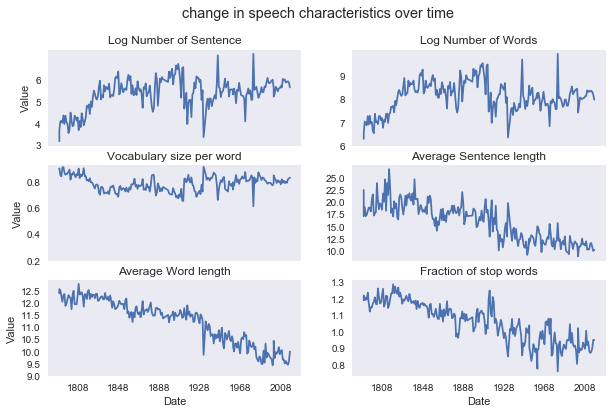

In [9]:
# Use Seaborn to provide a plot such as this, and discuss:
import math 
log_n_sent=[]
for i in addresses['n_sent']:
    log_n_sent=np.append(log_n_sent,math.log(i,math.e))
    
log_n_words=[]
for i in addresses['n_words']:
    log_n_words=np.append(log_n_words,math.log(i,math.e))
    

vocab_per_word=(addresses['n_swords'])/addresses['n_uwords']
mean_word_length=addresses['n_chars']/addresses['n_words']
mean_sent_length=addresses['n_words']/addresses['n_sent']
frac_stop_word=(addresses['n_words_all']-addresses['n_words'])/addresses['n_words']
Date=addresses['date'].dt.year

f1,axarr = plt.subplots(3,2,sharex=True)
ax=plt.gca()
#set title and range of x axies
plt.suptitle( 'change in speech characteristics over time')
plt.xticks(np.arange(1808,2009,40))
#plot[0][0], Date v.s. Log Number of Sentence
axarr[0,0].set_ylabel("Value")
axarr[0,0].set_title("Log Number of Sentence")
axarr[0,0].plot(Date,log_n_sent)
axarr[0,0].set_yticks(np.arange(3,7,1))

#plot[0][1], Date v.s. Log Number of Words
axarr[0,1].set_title("Log Number of Words")
axarr[0,1].plot(Date,log_n_words)
axarr[0,1].set_yticks(np.arange(6,10,1))

#plot[1][0], Date v.s. Vocabulary size per word
axarr[1][0].set_ylabel("Value")
axarr[1,0].set_title("Vocabulary size per word")
axarr[1,0].plot(Date,vocab_per_word)
axarr[1,0].set_yticks(np.arange(0.2,0.8,0.2)) 

#plot[1][1], Date v.s. Average Sentence length
axarr[1,1].set_title("Average Sentence length")
axarr[1,1].plot(Date,mean_sent_length)
axarr[1,1].set_yticks(np.arange(10,27.5,2.5)) 

#plot[2][0], Date v.s. Average Word length
axarr[2,0].plot(Date,mean_word_length)
axarr[2,0].set_title("Average Word length")
axarr[2][0].set_ylabel("Value")
axarr[2][0].set_xlabel("Date")
axarr[2,0].set_yticks(np.arange(9,13,0.5)) 
# ax.set_yticks(np.linspace(9,13,8))
# ax.yaxis.set_ticks(np.arange(9, 13, 8))
#plot[2][1], Date v.s. Fraction of stop words
axarr[2,1].plot(Date,frac_stop_word)
axarr[2,1].set_title("Fraction of stop words")
axarr[2][1].set_xlabel("Date")
axarr[2,1].set_yticks(np.arange(0.8,1.4,0.1))  
#plt.savefig("fig/speech_changes.png")

Now for the distributions by president

In [10]:
# add variable to original data frame
addresses["log_n_sent"]=log_n_sent
addresses["log_n_words"]=log_n_words
addresses["vocab_per_word"]=(addresses['n_swords'])/addresses['n_uwords']
addresses["mean_word_length"]=addresses['n_chars']/addresses['n_words']
addresses["mean_sent_length"]=addresses['n_words']/addresses['n_sent']
addresses["frac_stop_word"]=(addresses['n_words_all']-addresses['n_words'])/addresses['n_words']
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars,log_n_sent,log_n_words,vocab_per_word,mean_word_length,mean_sent_length,frac_stop_word
0,George Washington,State of the Union Address,1790-01-08,24.0,1178.0,538.0,398.0,356.0,6753.0,3.18,6.29,0.89,12.55,22.42,1.19
1,George Washington,State of the Union Address,1790-12-08,40.0,1515.0,683.0,516.0,463.0,8455.0,3.69,6.53,0.90,12.38,17.07,1.22
2,George Washington,State of the Union Address,1791-10-25,60.0,2487.0,1136.0,740.0,626.0,14203.0,4.09,7.04,0.85,12.50,18.93,1.19
3,George Washington,State of the Union Address,1792-11-06,61.0,2298.0,1042.0,693.0,580.0,12764.0,4.11,6.95,0.84,12.25,17.08,1.21
4,George Washington,State of the Union Address,1793-12-03,56.0,2132.0,972.0,720.0,652.0,11696.0,4.03,6.88,0.91,12.03,17.36,1.19


In [11]:
addresses_melted = addresses.melt("president")
addresses_melted
# plt.savefig("fig/speech_characteristics.png");
# Create variable with TRUE if variable is log_n_sent
lognsentence=addresses_melted['variable']=="log_n_sent"
# Select all casess where nationality is USA and age is greater than 50
df1=addresses_melted[lognsentence]
df1.head()

,president,variable,value
1816,George Washington,log_n_sent,3.2
1817,George Washington,log_n_sent,3.7
1818,George Washington,log_n_sent,4.1
1819,George Washington,log_n_sent,4.1
1820,George Washington,log_n_sent,4


In [12]:
# YOUR CODE HERE
#plt.savefig("fig/speech_characteristics.png");
sns.violinplot(data=df1, x="president", y="value")

AttributeError: 'float' object has no attribute 'shape'

## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [ ]:
speech_words=speeches
stop=stopwords.words("english")+list(string.punctuation)
speech_words=[]
speeches_cleaned=[]
stemmer=PorterStemmer()
for i in np.arange(len(speeches)):
    speeches_cleaned.append(set([stemmer.stem(word) for word in nltk.word_tokenize(speeches[i]) if word not in stop]))

In [12]:
addresses.to_hdf('results/df2.h5', 'addresses')

with shelve.open('results/vars2') as db:
    db['speech_words'] = speech_words
    db['speeches_cleaned'] = speeches_cleaned